# Project 2 - Continuous Control

---


### <p style="text-align: center;">Miguel Carreira Neves</p>
<p style="text-align: center;">22/03/2022</p>

---

This notebook is a proposed solution using Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

For a detailed description of **how to run** this project and all dependencies needed check the `README.md`.

For more information and **implementation details** check the `Report.md`. It contains information about the network description, the agent details, interpretation of obtained results and possible future work ideas .

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed all necessary dependencies.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ddpg_agent import Agent

import sys
print (sys.version) # Python Version

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


Choose between Single or Multi Agent enviroment

In [3]:
env = UnityEnvironment(file_name="./Reacher_Linux_single_agent/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 2.1 Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 3.1 Runner

In [7]:
def runner(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, score_obj=30):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        score_obj (int): score objective to stop at when average is reached and save model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    exit = False
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        agent.next_episode(i_episode)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            #torch.save(agent, 'agent_checkpoint.pth')
            #continueTrain = input('\Do you want to continue? 0-Yes 1-No')
            #if continueTrain == "1":
                #exit = True
        if np.mean(scores_window)>=score_obj or exit is True:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            #torch.save(agent, 'agent_checkpoint.pth')
            '''
            torch.save({
            'i_episode': i_episode,
            'actor_state_dict': agent.actor_local.state_dict(),
            'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
            'actor_loss': agent.actor_loss,
            'critic_state_dict': agent.critic_local,
            'critic_optimizer_state_dict': agent.critic_optimizer.state_dict(),
            'critic_loss': agent.critic_loss,
            'replay_buffer': agent.memory.memory
            }, 'agent.pth')
            '''
            break
    torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
    torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
    return scores

### 3.3 Initiate the Agents

In [8]:
# Instantiate the Agent
agent = Agent(state_size=state_size,action_size=action_size, random_seed=0, actor_fc1_units=128, actor_fc2_units=128,
                critic_fc1_units=128, critic_fc2_units=128,
                buffer_size=int(1e5), batch_size=128,
                gamma=0.99, tau=1e-3 ,
                lr_actor=2e-4, lr_critic=5e-4, weight_decay=0, batch_norm=True, add_ounoise=150, dropout_prob=0.)


DDPG called with params: state_size=33 action_size=4 random_seed=0 actor_fc1_units=128 actor_fc2_units=128 critic_fc1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 lr_actor=0.0002 lr_critic=0.0005 weight_decay=0 batch_norm=True add_ounoise=150 mu=0.0 theta=0.15 sigma=0.2 dropout_prob=0.0 



### 4. Train the Agent

Select whether to train it from the ground up or continue training from a model in memory.

If the model achieves the desired goal it will save itself onto a file and the training will finish.

In [9]:
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

#agent.qnetwork_local.train()
fromMemory = input("Do you want to train using a network from memory? 0-Yes 1-No ")
score_objective = int(input("What is the score average over 100 episodes that you want to achieve?\n(Recommended a score of 30 when training a new network)\n"))
if fromMemory == "0":
    print("Continuing from Memory...")
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))
    agent.qnetwork_target.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))
    scores = dqn(eps_start=0.02, score_obj=score_objective)
else:
    print("Training from the ground up with single agent enviroment...")
    scores = runner(n_episodes=300, score_obj=score_objective)

Do you want to train using a network from memory? 0-Yes 1-No 1
What is the score average over 100 episodes that you want to achieve?
(Recommended a score of 30 when training a new network)
30
Training from the ground up with single agent enviroment...
Episode 100	Average Score: 7.18
Episode 200	Average Score: 22.38
Episode 300	Average Score: 15.78


In [1]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_num = []
averages_100 = []
score_sum = 0
score_sum_100 = 0
i = 1
x_episodes = 25
for score in scores:
    score_sum+=score
    score_sum_100+=score
    if i%x_episodes == 0:
        score_sum = score_sum/x_episodes
        for j in range(0,x_episodes):
            averages_num.append(score_sum)
        if i%100 == 0:
            score_sum_100 = score_sum_100/100
            for j in range(0,100):
                averages_100.append(score_sum_100)
            score_sum_100 = 0
        score_sum=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score per Episode')
plt.plot(np.arange(len(averages_num)), averages_num, label='Avg Score Over ' +str(x_episodes)+ ' Episodes')
plt.plot(np.arange(len(averages_100)), averages_100, label='Avg Score Over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

NameError: name 'scores' is not defined

### 5. Test and Watch the Agent

See how the Agent behaves in the enviroment after being trained. Choose if you want the model to be loaded from a file or to use the one just trained.

In [11]:
# load the weights from file
#agent = Agent(state_size=state_size, action_size=action_size)
fromMemory = input("Do you want to test using network from memory? 0-Yes 1-No ")
if fromMemory == "0":
    print("Continuing from Memory...")
    #agent = torch.load('agent.pth',map_location=torch.device('cpu'))
    agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth',map_location=torch.device('cpu')))
    agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth',map_location=torch.device('cpu')))
else:
    print("Using the current trained network. If no one has previously been trained agent will act randomly.")
agent.actor_local.eval()
agent.critic_local.eval()
max_t = 1000
scores_test = []

test_episodes = 100
for episode in range(test_episodes):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
    score = 0
    for t in range(max_t):
        
        action = agent.act(state)
        env_info = env.step(action)[brain_name]

        state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]
        score += reward
        if done:
            break 
    scores_test.append(score)
    print("Episode: " + str(episode+1) + " Score: " + str(score))
            

Do you want to test using network from memory? 0-Yes 1-No 0
Continuing from Memory...
Episode: 1 Score: 25.09999943897128
Episode: 2 Score: 15.099999662488699
Episode: 3 Score: 10.749999759718776
Episode: 4 Score: 18.059999596327543
Episode: 5 Score: 26.94999939762056
Episode: 6 Score: 31.189999302849174
Episode: 7 Score: 27.53999938443303
Episode: 8 Score: 31.399999298155308
Episode: 9 Score: 39.139999125152826
Episode: 10 Score: 38.10999914817512
Episode: 11 Score: 17.629999605938792
Episode: 12 Score: 30.04999932833016
Episode: 13 Score: 14.90999966673553
Episode: 14 Score: 35.73999920114875
Episode: 15 Score: 14.689999671652913
Episode: 16 Score: 28.959999352693558
Episode: 17 Score: 39.23999912291765
Episode: 18 Score: 17.279999613761902
Episode: 19 Score: 11.359999746084213
Episode: 20 Score: 19.269999569281936
Episode: 21 Score: 13.299999702721834
Episode: 22 Score: 12.789999714121222
Episode: 23 Score: 10.139999773353338
Episode: 24 Score: 29.0499993506819
Episode: 25 Score: 15

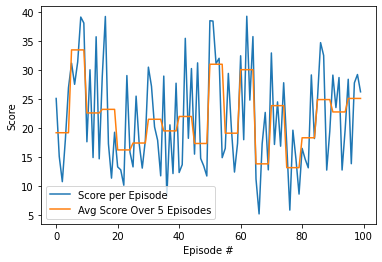

Avg Score Over All Episodes - 21.731699514258654


In [12]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_test = []
score_sum_test = 0
i = 1
test_episodes_avg = 5
for score in scores_test:
    score_sum_test+=score
    if i%test_episodes_avg == 0:
        score_sum_test = score_sum_test/test_episodes_avg
        for j in range(0,test_episodes_avg):
            averages_test.append(score_sum_test)
        score_sum_test=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test, label='Score per Episode')
plt.plot(np.arange(len(averages_test)), averages_test, label='Avg Score Over ' +str(test_episodes_avg)+ ' Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

print('Avg Score Over All Episodes - ' + str(sum(averages_test)/len(averages_test)))

In [17]:
torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')

RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1544174967633/work/torch/csrc/generic/serialization.cpp:15

In [8]:
env.close()

### Congrats you finished experimenting with this Project

Read the Report.md for information on Future Work and implementation details

### 3.2 Runner Multi Agent

In [8]:
def runner_multi(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, score_obj=40):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        score_obj (int): score objective to stop at when average is reached and save model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    exit = False
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        for t in range(max_t):   
            actions = []
            for agent,state in zip(agents,states): # select an action (for each agent)
                action = agent.act(state, eps) 
                actions.append(action)
            env_info = env.step(actions)[brain_name]#      send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                   # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for agent,state,action,reward,next_state,done in zip(agents,states,actions,rewards,next_states,dones):
                agent.step(state, action, reward, next_state, done) # learn step (for each agent)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        avg_scores = scores / len(agents) # average score of all agents
        score = sum_(avg_scores,len(avg_scores))
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            continueTrain = input('\Do you want to continue? 0-Yes 1-No')
            if continueTrain == "1":
                exit = True
        if np.mean(scores_window)>=score_obj or exit is True:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores